In [2]:
import pandas as pd

df = pd.read_csv('drive/My Drive/FGA/Toronto Bikeshare Data/2017 Data/Bikeshare Ridership (2017 Q1).csv')
df

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
0,712382,1/1/2017 0:00,1/1/2017 0:03,223,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member
1,712383,1/1/2017 0:00,1/1/2017 0:05,279,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member
2,712384,1/1/2017 0:05,1/1/2017 0:29,1394,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member
3,712385,1/1/2017 0:07,1/1/2017 0:21,826,7077,College Park South,7010,King St W / Spadina Ave,Member
4,712386,1/1/2017 0:08,1/1/2017 0:12,279,7079,McGill St / Church St,7047,University Ave / Gerrard St W,Member
...,...,...,...,...,...,...,...,...,...
132118,868705,31/03/2017 23:49,1/4/2017 0:09,1222,7029,Bay St / Bloor St W,7017,Widmer St / Adelaide St,Member
132119,868661,31/03/2017 23:49,31/03/2017 23:57,489,7006,Bay St / College St (East Side),7066,Willcocks St / St. George St,Member
132120,868662,31/03/2017 23:49,31/03/2017 23:57,442,7006,Bay St / College St (East Side),7066,Willcocks St / St. George St,Member
132121,868663,31/03/2017 23:52,1/4/2017 0:10,1116,7057,Simcoe St / Wellington St W,7023,College St W / Borden St,Member


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132123 entries, 0 to 132122
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   trip_id                132123 non-null  int64 
 1   trip_start_time        132123 non-null  object
 2   trip_stop_time         132123 non-null  object
 3   trip_duration_seconds  132123 non-null  int64 
 4   from_station_id        132123 non-null  int64 
 5   from_station_name      132123 non-null  object
 6   to_station_id          132123 non-null  int64 
 7   to_station_name        132123 non-null  object
 8   user_type              132123 non-null  object
dtypes: int64(4), object(5)
memory usage: 9.1+ MB


In [4]:
from datetime import datetime, timedelta

# Datetime dalam UTC, bukan Toronto Timezone. Ubah dulu ke Toronto Time (-4 hours)
df['trip_start_time'] = df['trip_start_time'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M') - timedelta(hours=4))
df['trip_stop_time'] = df['trip_stop_time'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M') - timedelta(hours=4))

In [5]:
df['hour_start'] = df['trip_start_time'].apply(lambda time: time.hour)
df['month_start'] = df['trip_start_time'].apply(lambda time: time.month)
df['weekday_start'] = df['trip_start_time'].apply(lambda time: time.dayofweek)

df['hour_stop'] = df['trip_stop_time'].apply(lambda time: time.hour)
df['month_stop'] = df['trip_stop_time'].apply(lambda time: time.month)
df['weekday_stop'] = df['trip_stop_time'].apply(lambda time: time.dayofweek)

In [6]:
mon = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
       7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['month_start'] = df['month_start'].map(mon)
df['month_stop'] = df['month_stop'].map(mon)

day = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['weekday_start'] = df['weekday_start'].map(day)
df['weekday_stop'] = df['weekday_stop'].map(day)

In [7]:
df['is_weekend_start'] = df['weekday_start'].apply(lambda x: 1 if x == 'Sat' or x == 'Sun' else 0)
df['is_weekend_stop'] = df['weekday_stop'].apply(lambda x: 1 if x == 'Sat' or x == 'Sun' else 0)

In [8]:
import requests
import json

req = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
stations = json.loads(req.content)['data']['stations']
stations[:1]

[{'address': 'Fort York  Blvd / Capreol Ct',
  'altitude': 0.0,
  'capacity': 35,
  'groups': [],
  'lat': 43.639832,
  'lon': -79.395954,
  'name': 'Fort York  Blvd / Capreol Ct',
  'nearby_distance': 500.0,
  'obcn': '647-643-9607',
  'physical_configuration': 'REGULAR',
  'rental_methods': ['KEY', 'CREDITCARD', 'TRANSITCARD', 'PHONE'],
  'station_id': '7000'}]

In [9]:
stations = pd.DataFrame(stations)[['station_id', 'name', 'lat', 'lon']].astype({'station_id': 'float64',})
stations.head()

,station_id,name,lat,lon
0,7000.0,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001.0,Lower Jarvis St / The Esplanade,43.647830,-79.370698
2,7002.0,St. George St / Bloor St W,43.667333,-79.399429
3,7003.0,Madison Ave / Bloor St W,43.667158,-79.402761
4,7004.0,University Ave / Elm St,43.656518,-79.389099


In [10]:
from collections import defaultdict

d = defaultdict(str)
for i in range(len(stations)):
  d[stations['station_id'][i]] = [stations['lat'][i], stations['lon'][i]]

In [11]:
# 2 stations in the dataset are not in the list of available stations, so map to the closest
df.loc[df['to_station_id'] == 7068, 'to_station_id'] = 7399
df.loc[df['to_station_id'] == 7219, 'to_station_id'] = 7148
df.loc[df['from_station_id'] == 7068, 'from_station_id'] = 7399
df.loc[df['from_station_id'] == 7219, 'from_station_id'] = 7148

In [12]:
import numpy as np

def get_lat_lon(x, i):
  get = np.nan
  try:
    get = d[x][i]
  except:
    pass
  return get

In [13]:
df['lat_start'] = df['from_station_id'].apply(lambda x: get_lat_lon(x, 0))
df['lon_start'] = df['from_station_id'].apply(lambda x: get_lat_lon(x, 1))
df['lat_stop'] = df['to_station_id'].apply(lambda x: get_lat_lon(x, 0))
df['lon_stop'] = df['to_station_id'].apply(lambda x: get_lat_lon(x, 1))

In [14]:
# https://www.geeksforgeeks.org/program-distance-two-points-earth/
from math import radians, cos, sin, asin, sqrt 

def distance(lat1, lat2, lon1, lon2): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r) 
      
      						
# driver code  
lat1 = 43.645599
lat2 = 43.687323
lon1 = -79.465712
lon2 =  -79.304848
print(distance(lat1, lat2, lon1, lon2), "KM") 

13.74576407856123 KM


In [16]:
df['distance'] = df.apply(lambda df: distance(df['lat_start'], df['lat_stop'], df['lon_start'], df['lon_stop']), axis=1)

In [18]:
df['avg_speed_km_per_hour'] = df.apply(lambda df: df['distance']/df['trip_duration_seconds'] * 60 * 60, axis=1)

In [19]:
df.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,hour_start,month_start,weekday_start,hour_stop,month_stop,weekday_stop,is_weekend_start,is_weekend_stop,lat_start,lon_start,lat_stop,lon_stop,distance,avg_speed_km_per_hour
0,712382,2016-12-31 20:00:00,2016-12-31 20:03:00,223,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.665060,-79.383570,43.662712,-79.379903,0.393919,6.359232
1,712383,2016-12-31 20:00:00,2016-12-31 20:05:00,279,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.671513,-79.408317,43.666667,-79.411667,0.602481,7.773942
2,712384,2016-12-31 20:05:00,2016-12-31 20:29:00,1394,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.665278,-79.368333,43.656389,-79.409167,3.430265,8.858647
3,712385,2016-12-31 20:07:00,2016-12-31 20:21:00,826,7077,College Park South,7010,King St W / Spadina Ave,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.659777,-79.382767,43.645323,-79.395003,1.884738,8.214355
4,712386,2016-12-31 20:08:00,2016-12-31 20:12:00,279,7079,McGill St / Church St,7047,University Ave / Gerrard St W,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.660694,-79.379052,43.657763,-79.389165,0.876393,11.308302


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


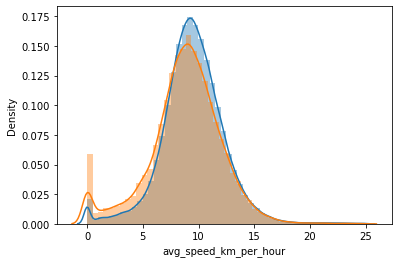

In [20]:
import seaborn as sns

sns.distplot(df.loc[(df['avg_speed_km_per_hour'] < 25) & (df['is_weekend_start'] == 0)]['avg_speed_km_per_hour'])
sns.distplot(df.loc[(df['avg_speed_km_per_hour'] < 25) & (df['is_weekend_start'] == 1)]['avg_speed_km_per_hour'])

In [21]:
df['distance'].max()

13.852614241576672

Jarak antar station terjauh adalah 13.8 Km. Tetapi ini adalah jarak garis lurus, bukan jarak tempuh sebenarnya. Jarak tempuh sebenarnya bisa saja 2 kali lipat atau sekitar 26 Km

In [22]:
print('minimum speed:', df['avg_speed_km_per_hour'].min())
print('maximum speed:', df['avg_speed_km_per_hour'].max())

minimum speed: 0.0
maximum speed: 515.4670047406305


In [23]:
df[df['avg_speed_km_per_hour'] < 25]

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,hour_start,month_start,weekday_start,hour_stop,month_stop,weekday_stop,is_weekend_start,is_weekend_stop,lat_start,lon_start,lat_stop,lon_stop,distance,avg_speed_km_per_hour
0,712382,2016-12-31 20:00:00,2016-12-31 20:03:00,223,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.665060,-79.383570,43.662712,-79.379903,0.393919,6.359232
1,712383,2016-12-31 20:00:00,2016-12-31 20:05:00,279,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.671513,-79.408317,43.666667,-79.411667,0.602481,7.773942
2,712384,2016-12-31 20:05:00,2016-12-31 20:29:00,1394,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.665278,-79.368333,43.656389,-79.409167,3.430265,8.858647
3,712385,2016-12-31 20:07:00,2016-12-31 20:21:00,826,7077,College Park South,7010,King St W / Spadina Ave,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.659777,-79.382767,43.645323,-79.395003,1.884738,8.214355
4,712386,2016-12-31 20:08:00,2016-12-31 20:12:00,279,7079,McGill St / Church St,7047,University Ave / Gerrard St W,Member,20,Dec,Sat,20,Dec,Sat,1,1,43.660694,-79.379052,43.657763,-79.389165,0.876393,11.308302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132118,868705,2017-03-31 19:49:00,2017-03-31 20:09:00,1222,7029,Bay St / Bloor St W,7017,Widmer St / Adelaide St,Member,19,Mar,Fri,20,Mar,Fri,0,0,43.669430,-79.389150,43.647508,-79.391484,2.444881,7.202595
132119,868661,2017-03-31 19:49:00,2017-03-31 19:57:00,489,7006,Bay St / College St (East Side),7066,Willcocks St / St. George St,Member,19,Mar,Fri,19,Mar,Fri,0,0,43.660439,-79.385525,43.662085,-79.397735,0.999107,7.355387
132120,868662,2017-03-31 19:49:00,2017-03-31 19:57:00,442,7006,Bay St / College St (East Side),7066,Willcocks St / St. George St,Member,19,Mar,Fri,19,Mar,Fri,0,0,43.660439,-79.385525,43.662085,-79.397735,0.999107,8.137521
132121,868663,2017-03-31 19:52:00,2017-03-31 20:10:00,1116,7057,Simcoe St / Wellington St W,7023,College St W / Borden St,Member,19,Mar,Fri,20,Mar,Fri,0,0,43.645857,-79.385365,43.657100,-79.405600,2.052623,6.621365


In [24]:
col = ["trip_start_time",	"trip_stop_time",	"trip_duration_seconds",
       "from_station_name", "to_station_name", "distance", "avg_speed_km_per_hour"]
df[df['avg_speed_km_per_hour'] > 25][col].sort_values('avg_speed_km_per_hour', ascending=False).head()

,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,distance,avg_speed_km_per_hour
96591,2017-03-09 10:03:00,2017-03-09 10:05:00,96,Stephenson Ave / Main St,Danforth Ave / Westlake Ave,13.745787,515.467005
114587,2017-03-22 09:12:00,2017-03-22 09:14:00,104,Stephenson Ave / Main St,Danforth Ave / Westlake Ave,13.745787,475.815697
96029,2017-03-08 22:57:00,2017-03-08 22:59:00,108,Stephenson Ave / Main St,Danforth Ave / Westlake Ave,13.745787,458.192893
16294,2017-01-16 10:08:00,2017-01-16 10:10:00,109,Stephenson Ave / Main St,Danforth Ave / Westlake Ave,13.745787,453.989289
61006,2017-02-16 12:44:00,2017-02-16 12:46:00,116,Stephenson Ave / Main St,Danforth Ave / Westlake Ave,13.745787,426.593383


In [25]:
df['avg_speed_km_per_hour'].mean()

9.630353455366173

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


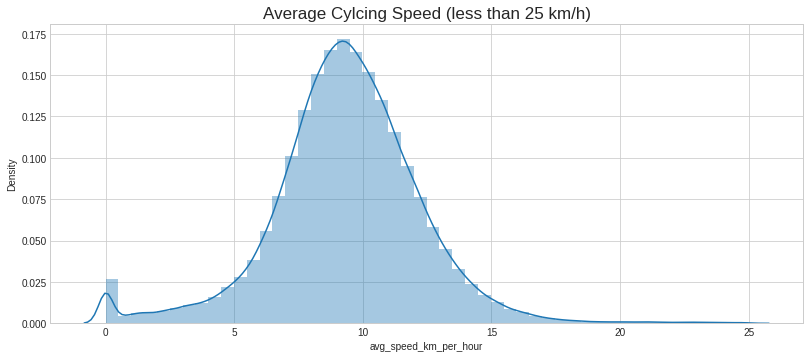

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(13.5, 5.5))

sns.distplot(df[df['avg_speed_km_per_hour'] < 25]['avg_speed_km_per_hour'], ax=ax)
ax.set_title('Average Cylcing Speed (less than 25 km/h)', fontsize=17)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


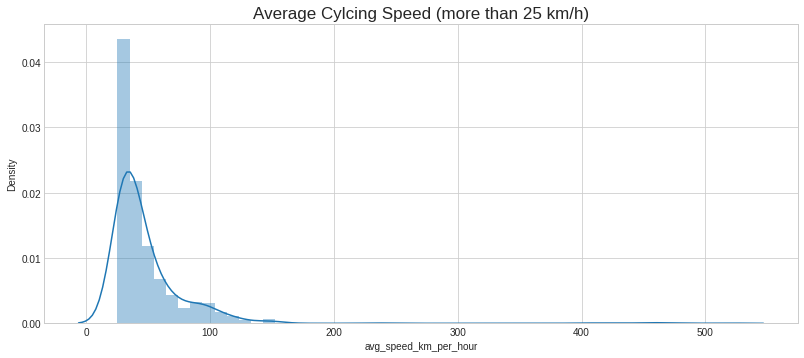

In [27]:
fig, ax = plt.subplots(figsize=(13.5, 5.5))

sns.distplot(df[df['avg_speed_km_per_hour'] > 25]['avg_speed_km_per_hour'], ax=ax)
ax.set_title('Average Cylcing Speed (more than 25 km/h)', fontsize=17)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


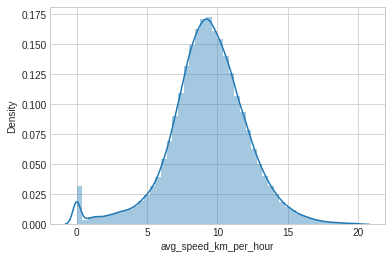

In [28]:
sns.distplot(df[df['avg_speed_km_per_hour'] < 20]['avg_speed_km_per_hour'])

515 km per jam bukan manusia yang bersepeda!!!!

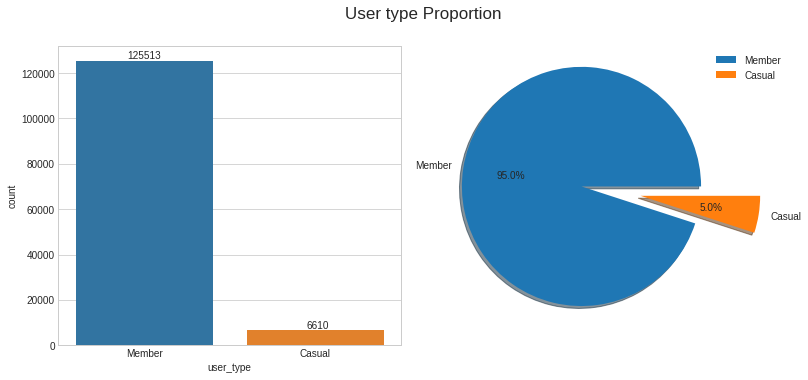

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='user_type', data=df, ax=ax1)
ax1.text(x=-0.1, y=len(df[df['user_type'] == 'Member'])+1000, s = len(df[df['user_type'] == 'Member']))
ax1.text(x=0.95, y=len(df[df['user_type'] == 'Casual'])+1000, s = len(df[df['user_type'] == 'Casual']))

ax2.pie(df['user_type'].value_counts(), shadow=True, explode=(0.5, 0), autopct='%1.1f%%', labels=['Member', 'Casual'])
ax2.legend()

plt.suptitle('User type Proportion', fontsize=17)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


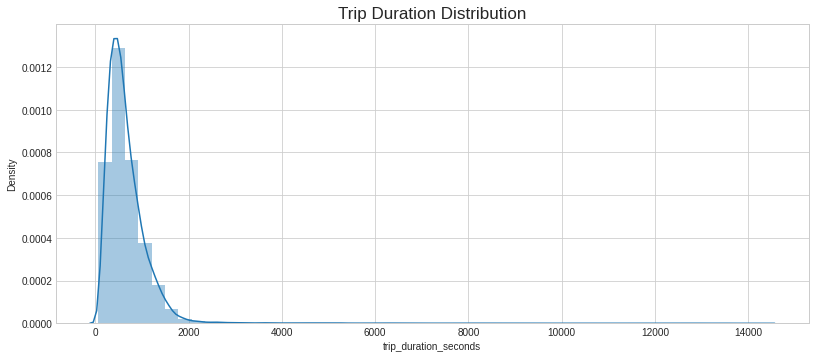

maximum trip duration: 14386 seconds. It is almost 4 hours
minimum trip duration: 60 seconds


In [30]:
fig, ax = plt.subplots(figsize=(13.5,5.5))

sns.distplot(df['trip_duration_seconds'], ax=ax)
ax.set_title('Trip Duration Distribution', fontsize=17)
plt.show()

print('maximum trip duration:', df['trip_duration_seconds'].max(), 'seconds. It is almost 4 hours')
print('minimum trip duration:', df['trip_duration_seconds'].min(), 'seconds')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


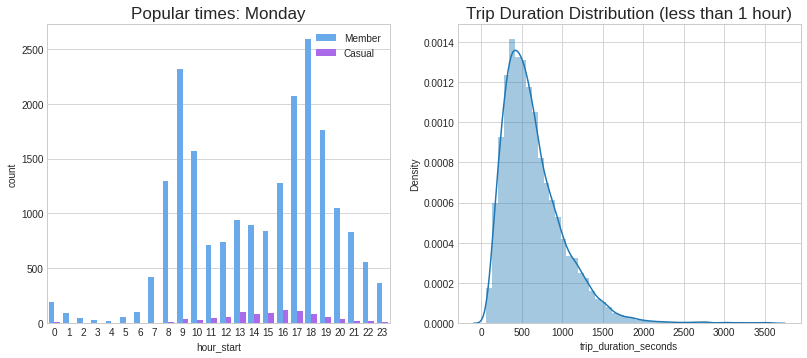

In [31]:
fig, ax = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='hour_start', data=df[df['weekday_start'] == 'Mon'], hue='user_type', palette='cool', ax=ax[0])
ax[0].set_title('Popular times: Monday', fontsize=17)
ax[0].legend()

sns.distplot(df.loc[(df['weekday_start'] == 'Mon') & (df['trip_duration_seconds'] <= 3600)]['trip_duration_seconds'], ax=ax[1])
ax[1].set_title('Trip Duration Distribution (less than 1 hour)', fontsize=17)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


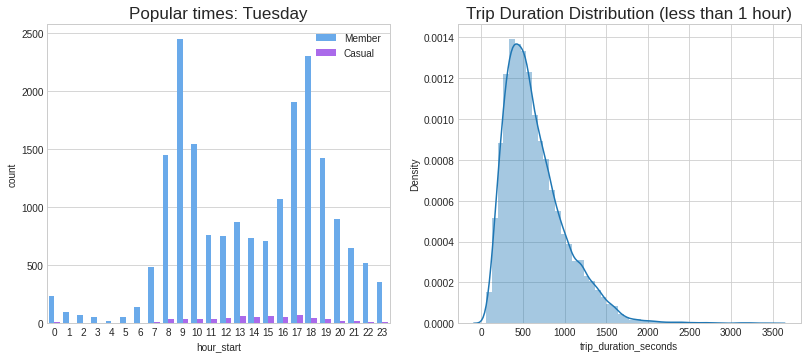

In [32]:
fig, ax = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='hour_start', data=df[df['weekday_start'] == 'Tue'], hue='user_type', palette='cool', ax=ax[0])
ax[0].set_title('Popular times: Tuesday', fontsize=17)
ax[0].legend()

sns.distplot(df.loc[(df['weekday_start'] == 'Tue') & (df['trip_duration_seconds'] <= 3600)]['trip_duration_seconds'], ax=ax[1])
ax[1].set_title('Trip Duration Distribution (less than 1 hour)', fontsize=17)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


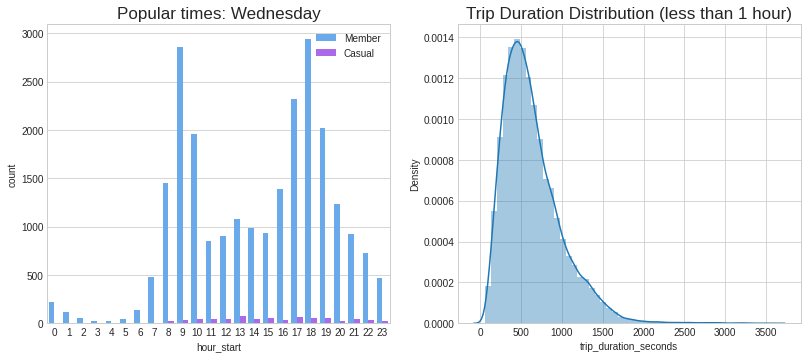

In [33]:
fig, ax = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='hour_start', data=df[df['weekday_start'] == 'Wed'], hue='user_type', palette='cool', ax=ax[0])
ax[0].set_title('Popular times: Wednesday', fontsize=17)
ax[0].legend()

sns.distplot(df.loc[(df['weekday_start'] == 'Wed') & (df['trip_duration_seconds'] <= 3600)]['trip_duration_seconds'], ax=ax[1])
ax[1].set_title('Trip Duration Distribution (less than 1 hour)', fontsize=17)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


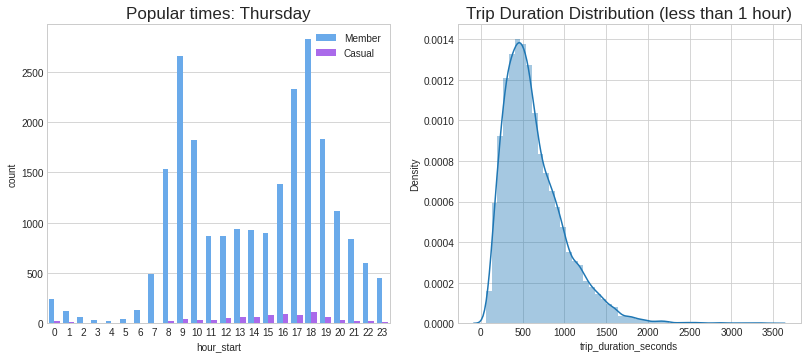

In [34]:
fig, ax = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='hour_start', data=df[df['weekday_start'] == 'Thu'], hue='user_type', palette='cool', ax=ax[0])
ax[0].set_title('Popular times: Thursday', fontsize=17)
ax[0].legend()

sns.distplot(df.loc[(df['weekday_start'] == 'Thu') & (df['trip_duration_seconds'] <= 3600)]['trip_duration_seconds'], ax=ax[1])
ax[1].set_title('Trip Duration Distribution (less than 1 hour)', fontsize=17)

plt.show()

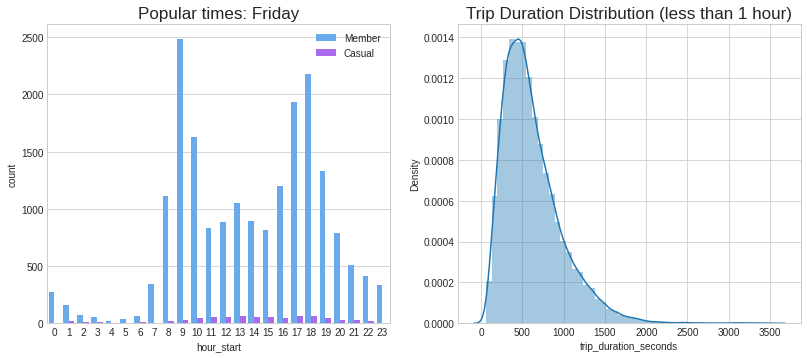

In [35]:
fig, ax = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='hour_start', data=df[df['weekday_start'] == 'Fri'], hue='user_type', palette='cool', ax=ax[0])
ax[0].set_title('Popular times: Friday', fontsize=17)
ax[0].legend()

sns.distplot(df.loc[(df['weekday_start'] == 'Fri') & (df['trip_duration_seconds'] <= 3600)]['trip_duration_seconds'], ax=ax[1])
ax[1].set_title('Trip Duration Distribution (less than 1 hour)', fontsize=17)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


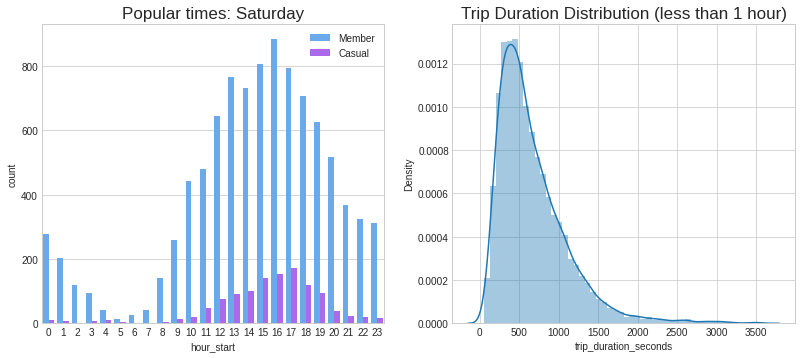

In [36]:
fig, ax = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='hour_start', data=df[df['weekday_start'] == 'Sat'], hue='user_type', palette='cool', ax=ax[0])
ax[0].set_title('Popular times: Saturday', fontsize=17)
ax[0].legend()

sns.distplot(df.loc[(df['weekday_start'] == 'Sat') & (df['trip_duration_seconds'] <= 3600)]['trip_duration_seconds'], ax=ax[1])
ax[1].set_title('Trip Duration Distribution (less than 1 hour)', fontsize=17)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


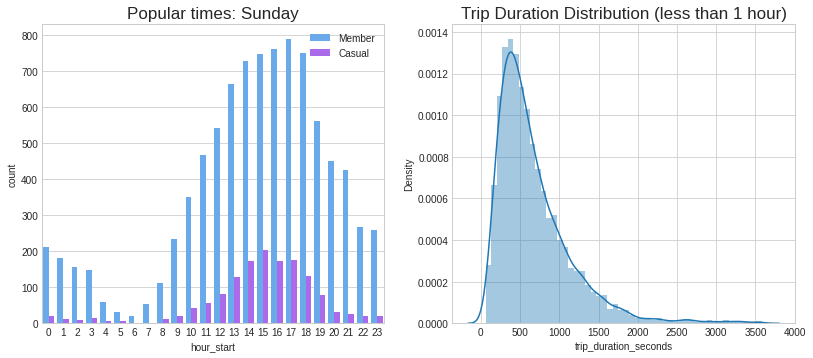

In [37]:
fig, ax = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='hour_start', data=df[df['weekday_start'] == 'Sun'], hue='user_type', palette='cool', ax=ax[0])
ax[0].set_title('Popular times: Sunday', fontsize=17)
ax[0].legend()

sns.distplot(df.loc[(df['weekday_start'] == 'Sun') & (df['trip_duration_seconds'] <= 3600)]['trip_duration_seconds'], ax=ax[1])
ax[1].set_title('Trip Duration Distribution (less than 1 hour)', fontsize=17)

plt.show()

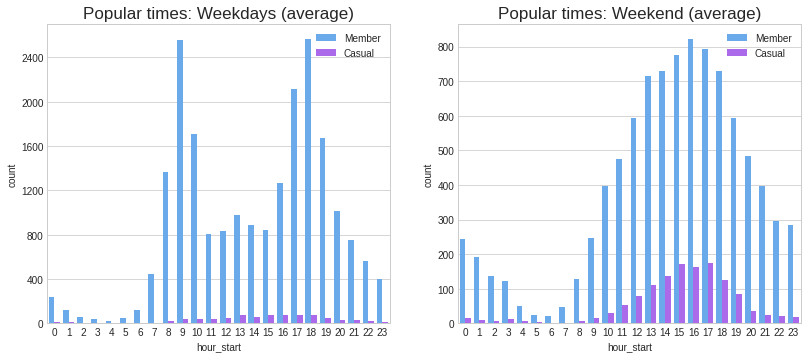

In [38]:
import numpy as np

fig, ax = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='hour_start', data=df[df['is_weekend_start'] == 0], hue='user_type', palette='cool', ax=ax[0])
ax[0].set_yticks(np.arange(0,13000,2000))
ax[0].set_yticklabels(np.arange(0,2600,400))
ax[0].set_title('Popular times: Weekdays (average)', fontsize=17)
ax[0].legend()

sns.countplot(x='hour_start', data=df[df['is_weekend_start'] == 1], hue='user_type', palette='cool', ax=ax[1])
ax[1].set_yticks(np.arange(0,1700,200))
ax[1].set_yticklabels(np.arange(0,850,100))
ax[1].set_title('Popular times: Weekend (average)', fontsize=17)
ax[1].legend()

plt.show()

Pengguna sepeda dengan annual member cukup padat di jam 8-9 am dan 5-6 pm pada weekdays. Pengguna sepeda dengan casual member cukup padat di siang menjelang sore hari yaitu 2-5 pm baik di weekdays maupun weekend. Kemungkinan pengguna annual member adalah penduduk sekitar yang biasa menggunakan bike share untuk keperluan berangkat dan pulang kerja. Dan pengguna casual member adalah turis atau orang yang singgah di Toronto. Pada weekend, pengguna annual member cukup padat di 2-5 pm seperti casual member.

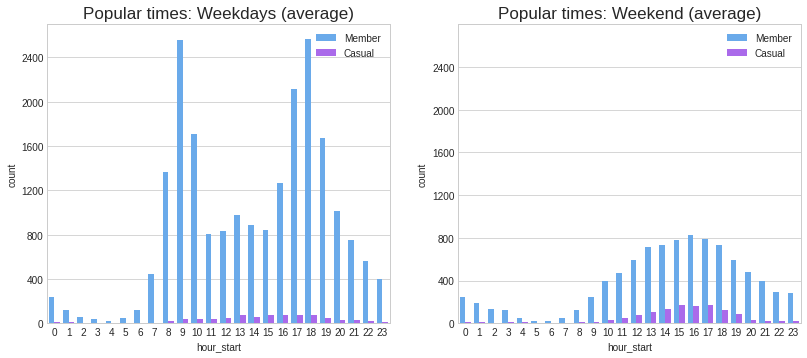

In [39]:
import numpy as np

fig, ax = plt.subplots(1,2, figsize=(13.5,5.5))

sns.countplot(x='hour_start', data=df[df['is_weekend_start'] == 0], hue='user_type', palette='cool', ax=ax[0])
ax[0].set_yticks(np.arange(0,13000,2000))
ax[0].set_yticklabels(np.arange(0,2600,400))
ax[0].set_title('Popular times: Weekdays (average)', fontsize=17)
ax[0].legend()

sns.countplot(x='hour_start', data=df[df['is_weekend_start'] == 1], hue='user_type', palette='cool', ax=ax[1])
ax[1].set_yticks(np.arange(0,5650,800))
ax[1].set_yticklabels(np.arange(0,2600,400))
ax[1].set_title('Popular times: Weekend (average)', fontsize=17)
ax[1].legend()

plt.show()

Plot di atas adalah True Scale

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


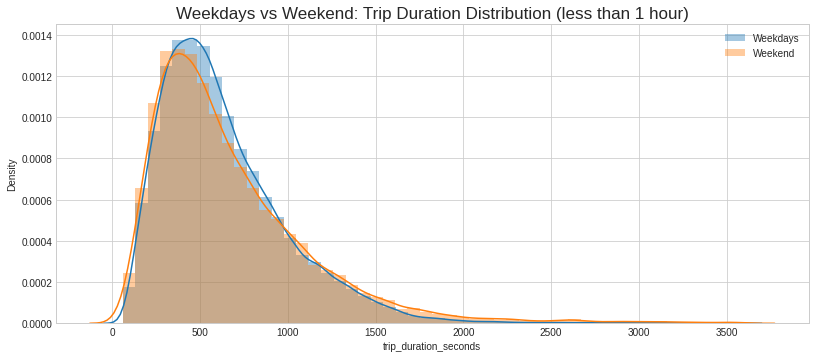

In [40]:
fig, ax = plt.subplots(figsize=(13.5,5.5))

sns.distplot(df.loc[(df['is_weekend_start'] == 0) & (df['trip_duration_seconds'] <= 3600)]['trip_duration_seconds'], ax=ax, label='Weekdays')
sns.distplot(df.loc[(df['is_weekend_start'] == 1) & (df['trip_duration_seconds'] <= 3600)]['trip_duration_seconds'], ax=ax, label='Weekend')
ax.set_title('Weekdays vs Weekend: Trip Duration Distribution (less than 1 hour)', fontsize=17)
ax.legend()

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


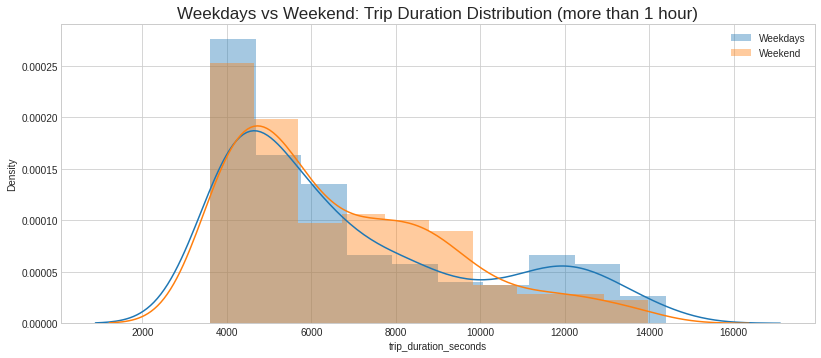

In [41]:
fig, ax = plt.subplots(figsize=(13.5,5.5))

sns.distplot(df.loc[(df['is_weekend_start'] == 0) & (df['trip_duration_seconds'] > 3600)]['trip_duration_seconds'], ax=ax, label='Weekdays')
sns.distplot(df.loc[(df['is_weekend_start'] == 1) & (df['trip_duration_seconds'] > 3600)]['trip_duration_seconds'], ax=ax, label='Weekend')
ax.set_title('Weekdays vs Weekend: Trip Duration Distribution (more than 1 hour)', fontsize=17)
ax.legend()

plt.show()

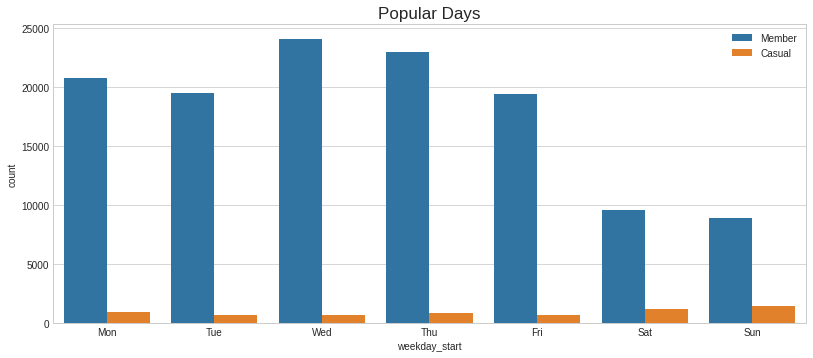

In [42]:
fig, ax = plt.subplots(figsize=(13.5,5.5))

list_day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.countplot(x='weekday_start', data=df, hue='user_type', order=list_day, ax=ax)
ax.set_title('Popular Days', fontsize=17)
ax.legend()
plt.show()

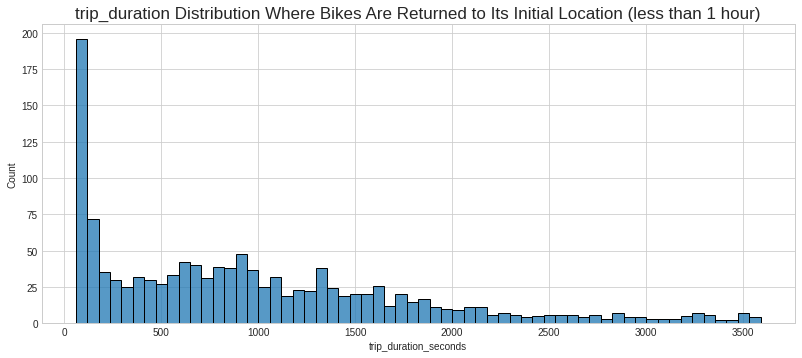

In [43]:
fig, ax = plt.subplots(figsize=(13.5,5.5))

sns.histplot(df[(df['from_station_name'] == df['to_station_name']) & (df['trip_duration_seconds'] < 3600)]['trip_duration_seconds'], bins=60, ax=ax)
ax.set_title('trip_duration Distribution Where Bikes Are Returned to Its Initial Location (less than 1 hour)', fontsize=17)

plt.show()

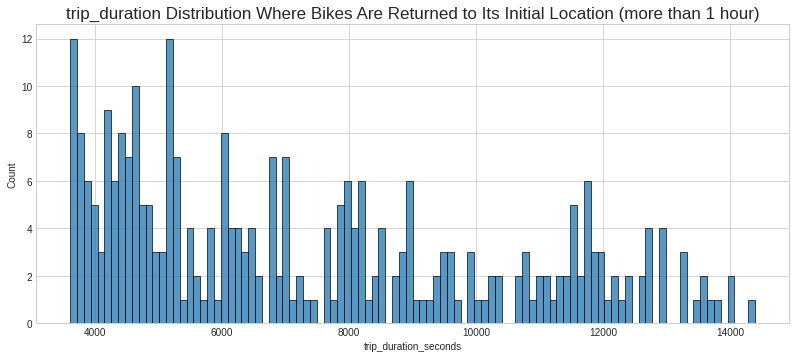

In [44]:
fig, ax = plt.subplots(figsize=(13.5,5.5))

sns.histplot(df[(df['from_station_name'] == df['to_station_name']) & (df['trip_duration_seconds'] > 3600)]['trip_duration_seconds'], bins=100, ax=ax)
ax.set_title('trip_duration Distribution Where Bikes Are Returned to Its Initial Location (more than 1 hour)', fontsize=17)

plt.show()

In [47]:
ans = len(df[df['from_station_id'] == df['to_station_id']])/len(df)

print('short answer:', ans*100, "%")

short answer: 1.1723923919378156 %


In [46]:
ans = len(df.loc[(df['trip_duration_seconds'] > 1800) & (df['avg_speed_km_per_hour'] < 9.6)])
total = len(df)

print('number of bikeshare trips usually visit more than just start/end points:', ans, 'out of', total, 'trips')
print('it is', ans/total * 100, '% from total trips')

number of bikeshare trips usually visit more than just start/end points: 2243 out of 132123 trips
it is 1.6976605133095675 % from total trips
